# Analysis of LIG Attributions


TODOS:
- compare BERT distilBERT
- fix viz html to png
- analyze what role position plays, any correls with attribution? esp. start / end


FRAGEN Michi/Lisanne:
- run BERT over whole test set?
- re-run with delta? do we need delta? (showing how "sure" about attributions)

## Imports, read & clean up data

In [1]:
import ast
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from captum.attr import visualization as viz
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from _stop_words import ENGLISH_STOP_WORDS

%matplotlib inline

In [22]:
# convert strings into lists
def literal_eval_column(column):
    try:
        return ast.literal_eval(column)
    except (SyntaxError, ValueError):
        return column


def read_dfs(directory):
    dataframes = []

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):  # check if the file is a CSV file
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            dataframes.append(df)

    # merge the DataFrames into a single DataFrame
    merged_df = pd.concat(dataframes, ignore_index=True)
    pd.set_option('display.max_colwidth', None)
    merged_df = merged_df.applymap(literal_eval_column)
    return merged_df

# check erroneous indices 
with open('nohup-att-dist4.out', 'r', encoding='utf-8') as f:
    lines = f.readlines()
error_indices = [int(l.split(' ')[0]) for l in lines[7:] if l]

gold = pd.read_csv('outputs/20newsgroups_test.csv', encoding='utf-8')
# exclude erroneous lines
gold = gold[~gold.index.isin(error_indices)]
gold = gold.reset_index()

def compare_pred(row):
    return 1 if row['label_pred'] == gold['label_text'][row.index] else 0

def postprocess(merged_df, whole_ds=True):
    """filter and compare to gold labels"""
    # exclude nan rows
    filtered = merged_df.dropna(subset='tokens')
    filtered = filtered.reset_index()
    # create gold label column
    filtered['label_gold'] = gold['label_text']
    filtered['correct'] = filtered.label_gold == filtered.label_pred
    # sum up attributions for a sentence
    filtered['sum_attributions'] = filtered['attributions'].apply(lambda x: sum(x) if isinstance(x, list) else None)
    filtered = filtered.drop(columns=['0', 'Unnamed: 0'])
    if whole_ds:  # not for subset of the dataset
        assert len(gold) == len(filtered)
    return filtered

In [16]:
merged_df = read_dfs(directory='outputs/distilbert/')
filtered = postprocess(merged_df)
# 215 empty strings in data, also some only one-char instances
len(filtered)

7309

In [17]:
filtered.tail()

,index,attributions,label_pred,score,tokens,label_gold,correct,sum_attributions
7304,8148,"[0.2254657002475486, 0.009065115322021058, -0.009150316763236062, -0.003143106979051881, -0.010697206380851495, 0.015213552445164289, -0.012899985830261302, 0.003563101235427921, 0.02441977485606486, -0.02644572075539405, 0.003117124293401044, 0.0016459422438876545, 0.017735771224790767, 0.0014874084580332628, -0.002444519516378151, 0.012524575278730186, 0.002173285318971033, -0.019771825140241554, -0.010258781664755894, 0.05800394050365725, 0.06579421001692458, 0.3017866427337154, 0.7253727412531141, -0.1309454823518646, 0.007148792094533798, -0.0012682902208346653, 0.007311723870991411, 0.00855368187734296, 0.14946534147610613, 0.02274758555754188, 0.007517953980450321, 0.03123912866547899, 0.02351463663876976, 0.09068084539782145, 0.009651181832458488, -0.007787446035201727, -0.0016140915639375343, 0.00088231799596552, 0.002550103514493196, 0.006930068036884605, -0.009214827514207631, -0.014201150662519672, 0.008450469082570418, 0.01802302026299982, 0.025666058692756576, -0.0014952033536586183, 0.06005559753475892, -0.009985599324509917, 0.014668800002905805, 0.03958682670933471, 0.0008235978272093267, 0.06436781276939971, 0.02401185652930182, -0.007792828089185653, -0.0100490395741241, -0.01088665726432056, -0.006495650218366321, 0.001718002444218399, 0.0024624305338297858, 0.011743060197204613, -0.02431484447591137, -0.004405267183521738, 0.00783764129310171, -0.0009158359166360939, 0.001462495053580161, 0.0015003241907410266, 0.006979489684770939, 0.12024286394897604, 0.2584192939431191, 0.21655204131772654, -0.06119288860435151, -0.10145212352554953, 0.02513794556005513, 0.0150504324799851, -0.01220766726502778, -0.003505420010957564, 0.023997898781527728, -0.0057693201424803865, 0.0047623214366474586, 0.004272676001608384, 0.0011515201413472458, -0.0003486969235090833, -0.0022949657014414778, 0.0033127638816984988, 0.0032367497277297442, 0.0033803451453405576, 0.01063422141720751, -0.0022541453095507973, 0.0031341090756636684, 0.012790399935366677, -0.021440064287180514, -0.0037220610410479502, -0.008037477989440555, 0.0020488552648790844, 4.94527537191541e-05, -0.00900436796346479, 0.0043293324609136805, 0.001582814478599764, 0.03236048088145881, 0.014213495544823205, ...]",sci.space,0.950029,"[henry, ,, if, i, read, you, correctly, ,, you, may, be, asking, "", if, i, put, a, black, ##body, in, inter, ##stellar, space, (, ', disregard, ##ing, the, sun, and, nearby, large, warm, objects, ', ), ,, what, term, ##per, ##at, ##ure, will, it, reach, in, thermal, equilibrium, with, the, ambient, radiation, field, ?, "", if, that, ', s, the, case, ,, let, me, point, out, that, inter, ##stellar, dust, and, molecules, provide, many, instances, of, things, that, are, ,, well, ,, not, -, too, -, far, from, being, black, ##bo, ##dies, ., many, different, observations, ,, including, ira, ##s, ...]",sci.space,True,3.299645
7305,8149,"[-0.10304464999994822, 0.03602233676625874, 0.01529925305221506, 0.01059182704898311, -0.068445083216066, 0.07984433473752293, 0.1190032263087656, 0.774137452931362, -0.12826371551497254, 0.24500425320515953, -0.07623544274947432, 0.06398884943451257, -0.08190492742520523, -0.027895776622693987, -0.010717559129610595, 0.017177033819404084, 0.36891615281400986, -0.009020338412780054, 0.04843837656343499, 0.0946842946252705, 0.0026835638802001124, 0.012374766684387663, 0.023710722000513103, -0.0164702569831656, 0.05309190791825658, -0.09838102882325188, 0.06275246715340609, 0.01736980510652462, 0.03148731112508472, -0.08134643445362444, -0.02966424062458395, 0.027066607735658155, 0.23493581249948675, 0.015248038196263705, 0.1868676498978269, -0.0273407071798576, 0.032309698181933744, -0.030501057124216097, 0.03785793903452128]",comp.sys.mac.hardware,0.768097,"[about, them, on, actually, ,, i, thought, mac, ##s, were, su, ##pp, ##ouse, ##d, to, be, restarted, once, a, day, ., -, -, jim, sm, ##yt, ##on, (, sm, ##yt, #

### Analyze attributions dataframe (min, max, correlations)

In [14]:
min(filtered.sum_attributions), max(filtered.sum_attributions)

(-1.3985433772675415, 14.190087651709247)

In [21]:
# corrcoeff (Pearson) = 0.25 -> weak or no correl
np.correlate(filtered.score, filtered.sum_attributions), np.corrcoef(filtered.score, filtered.sum_attributions)

(array([649.79005612]),
 array([[1.        , 0.25077146],
        [0.25077146, 1.        ]]))

In [22]:
np.corrcoef(filtered.score, filtered.tokens.apply(len))

array([[1.        , 0.24366537],
       [0.24366537, 1.        ]])

In [29]:
filtered.corr()

C:\Users\lydia\AppData\Local\Temp\ipykernel_8344\2012565923.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  filtered.corr()


,index,score,correct,sum_attributions
index,1.000000,-0.000086,0.011100,0.002758
score,-0.000086,1.000000,0.562889,0.353571
correct,0.011100,0.562889,1.000000,0.253217
sum_attributions,0.002758,0.353571,0.253217,1.000000


### Visualizations

In [9]:
def barplot_row(row, output=''):
    a = pd.Series(row['attributions'].tolist()[0], row['tokens'].tolist()[0])
    a.plot.barh(figsize=(10,20))
    if output:
         plt.savefig(f'{output}/{str(row.index[0])}.png', bbox_inches='tight')

In [55]:
from IPython.display import HTML, display, Image
import imgkit

def viz_row(row, output_path=''):
    viz_record = viz.VisualizationDataRecord(
        word_attributions=row['attributions'],
        pred_prob=row['score'],
        pred_class=row['label_pred'],
        true_class=row['label_gold'],
        # in LIG: target set to None, so defaults usually to target class, i.e. gold label?
        attr_class=row['label_gold'],
        attr_score=sum(row['attributions']),
        raw_input_ids=row['tokens'],
        convergence_score=0.)  # not needed for visualize_text
    # https://github.com/pytorch/captum/blob/b84980a8a7c4722f29b9693234bc255150da224a/captum/attr/_utils/visualization.py#L833
    visualization = viz.visualize_text([viz_record])
    if output_path:  # save to png
        Image(filename=output_path)
        #display(img)

In [57]:
viz_row(filtered.iloc[4], output_path='outputs/viz-distilbert/visualization.png')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
talk.religion.misc,alt.atheism (0.63),talk.religion.misc,1.37,i ' ve just spent two solid months arguing that no such thing as an objective moral system exists .


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/viz-distilbert/visualization.png'

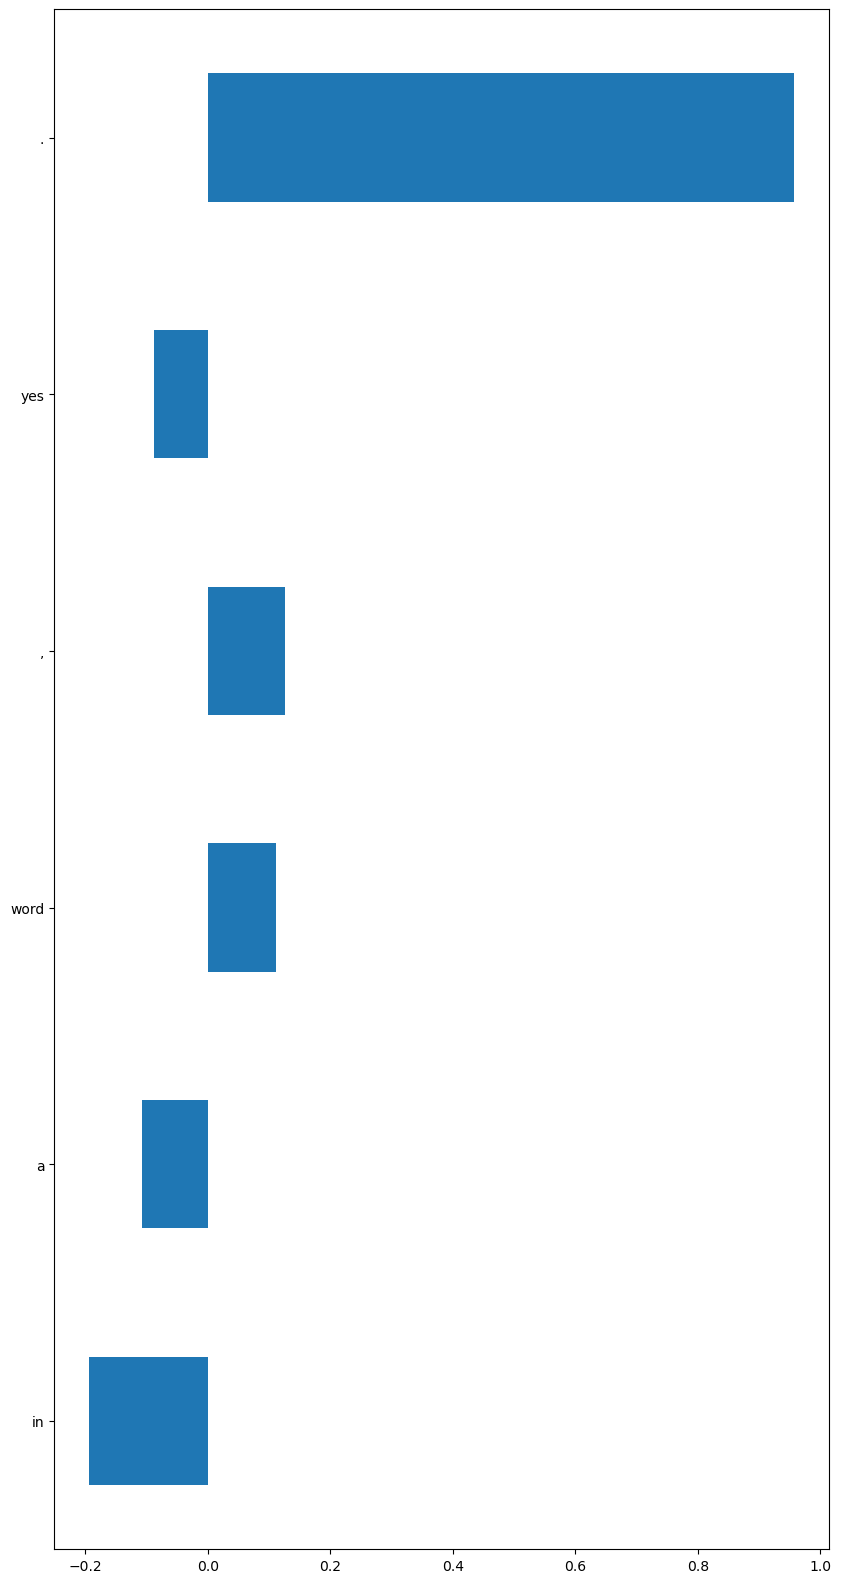

In [11]:
barplot_row(merged_df.iloc[[2]], output='outputs/viz-bert')

## Overall vocabulary & attributions analysis

In [6]:
labels = [
    "alt.atheism",
    "comp.graphics",
    "comp.os.ms-windows.misc",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
    "talk.religion.misc"
]

In [7]:
vocab_attributions = dict()
vocab_attributions_by_class = {label: dict() for label in labels}
vocab_counts = dict()
vocab_counts_by_class = dict()

ignore_stopwords = False
merge_subwords = True
aggregate = 'mean'

def dict_entries(token, attribution, by_class=True):
    if token in vocab_attributions:
            vocab_attributions[token].append(attribution)
    else:
        vocab_attributions[token] = [attribution]
    if by_class:
        if token in vocab_attributions_by_class[label]:
            vocab_attributions_by_class[label][token].append(attribution)
        else:
            vocab_attributions_by_class[label][token] = [attribution]


for k, row in filtered.iterrows():
    if type(row['tokens']) == float:
        continue
    assert len(row['attributions']) == len(row['tokens'])
    label = row['label_gold']
    # skip merged tokens
    skip_next_iteration = 0
    # iterate over tokens to save attributions
    for i, token in enumerate(row['tokens']):
        if skip_next_iteration != 0:
            skip_next_iteration -= 1
            continue
        if token:
            word = token
            attribution = row['attributions'][i]
            # detokenize
            if merge_subwords:
                # check whether next token starts with ##
                if i < len(row['tokens'])-1 and row['tokens'][i+1].startswith('##'):
                    # check whether further tokens start with ##
                    to_merge = row['tokens'][i:]
                    count = 1
                    iterator = iter(to_merge[1:])
                    while True:
                        try:
                            token = next(iterator)
                            if token.startswith("##"):
                                count += 1
                            else:
                                break
                        except StopIteration:
                            break
                    to_merge = to_merge[:count]
                    j = len(to_merge)
                    word = ''.join(row['tokens'][i:i+j]).replace('##', '')
                    attr = [row['attributions'][i:i+j]]
                    if aggregate == 'mean':
                        attribution = np.mean(attr)
                    skip_next_iteration = count-1
            # skip stop words
            if ignore_stopwords:
                if word in ENGLISH_STOP_WORDS:
                    continue
            # create or update dict entries with attributions
            dict_entries(word, attribution)

if ignore_stopwords:
    assert set(vocab_attributions.keys()).intersection(ENGLISH_STOP_WORDS) == {}


In [37]:
vocab_attributions_by_class

{'alt.atheism': {'in': [-0.19382938156955007,
   0.037745199185423794,
   0.03348229484877157,
   -0.0069002932884402925,
   0.005088587792657234,
   -0.01766677445111239,
   0.010027899801640284,
   -0.0017788840982321005,
   -0.005096426297986955,
   0.00788898830926347,
   -0.007329852162658207,
   -0.005368477216538616,
   0.05799464041065173,
   -0.013754701483842939,
   0.025821155130160634,
   0.022274810475093512,
   0.03301198982957887,
   0.003408437863668047,
   0.0035403664781250223,
   0.046443783264201274,
   0.01222256074105702,
   0.004690995071816764,
   0.020401640041024113,
   -0.0002173548859186238,
   0.05902917580495643,
   0.06345116272584787,
   -0.037077758292107334,
   0.06297322432691717,
   0.09994817868886631,
   0.004406283375716583,
   0.007622460221867813,
   0.003795749052586507,
   -0.0014702520918067684,
   0.0158466459645588,
   0.010819240601781691,
   0.000620741145010521,
   0.004447132516821423,
   -0.0009460613398302691,
   -0.004971333367652246

In [8]:
average_attr_by_class = {
    label: {
        token: np.mean([a for a in attr if isinstance(a, float)])
        for token, attr in labeldict.items()
    }
    for label, labeldict in vocab_attributions_by_class.items()
}

average_attr_by_class

{'alt.atheism': {'in': 0.010350806168192193,
  'a': 0.018906454562130356,
  'word': 0.05548777191790872,
  ',': 0.014501542223676687,
  'yes': 0.0009668648784938898,
  '.': 0.006664176550735332,
  'probably': 0.006177638488585817,
  'because': 0.009553180700561263,
  'it': 0.008141145374898164,
  'is': 0.011079131193100005,
  'rape': -0.06423984369862748,
  'so': 0.00875163298271794,
  'nothing': 0.011737295852016143,
  'may': 0.0034299397053873465,
  'work': 0.003063601553269253,
  'for': 0.0006876477687251775,
  'some': 0.007846193884042077,
  'but': 0.011771614513321555,
  'not': 0.0065649724833446756,
  'others': 0.011819279317229722,
  ':': 0.01127027195378619,
  'doesn': 0.012042113624232355,
  "'": 0.015968758452531397,
  't': 0.005500442759490368,
  'give': -0.004035659863033375,
  'any': 0.01179373351970375,
  'insight': 0.0277728855655861,
  'into': 0.017207664420295345,
  'an': 0.011680154584882179,
  'overall': 0.0007348789696913955,
  'god': 0.19689108628142363,
  'or': 0.

In [110]:
def sort_attr_dict(attr_dict):
    return dict(sorted(attr_dict.items(), key=lambda item: item[1], reverse=True))

In [111]:
len(set(average_attr_by_class["comp.os.ms-windows.misc"].keys()).intersection(set(average_attr_by_class["alt.atheism"].keys()))), \
len(set(average_attr_by_class["comp.os.ms-windows.misc"].keys()).difference(set(average_attr_by_class["alt.atheism"].keys())))

(2089, 3181)

In [112]:
len(set(average_attr_by_class["rec.motorcycles"].keys()).intersection(set(average_attr_by_class["alt.atheism"].keys()))), \
len(set(average_attr_by_class["rec.motorcycles"].keys()).difference(set(average_attr_by_class["alt.atheism"].keys())))

(2236, 3462)

In [113]:
sort_attr_dict(average_attr_by_class["alt.atheism"])

{'torah': 0.8946556105685459,
 'orbit': 0.8546828077404595,
 'heaven': 0.7760791843940474,
 'denomination': 0.7361201039831206,
 'gogh': 0.717660822401483,
 'prayer': 0.7042795988402561,
 'hebrew': 0.6768664017387269,
 'verb': 0.6209632433697962,
 'judaism': 0.6143038439717949,
 'christian': 0.5684182418121474,
 'soul': 0.5673833567912817,
 'default': 0.556653198802481,
 'gravitational': 0.5336895420875813,
 'weapon': 0.5329304508972978,
 'lyndon': 0.48430580968723597,
 'humanism': 0.4573461147674056,
 'charles': 0.4525712592256117,
 'islamic': 0.44497439500218183,
 'cooper': 0.4413515261864065,
 'noonan': 0.43497975758490887,
 'demon': 0.4324405969959177,
 'anarchist': 0.42754204138955004,
 'nasa': 0.4244598865235582,
 'prophetic': 0.4165009300929328,
 'luther': 0.40705963660678596,
 'dualism': 0.39790622355231003,
 'greeks': 0.3961972311060816,
 'weapons': 0.39503520913680096,
 'enemy': 0.3932885029757324,
 'gunman': 0.38574866903196847,
 'vor': 0.38555636734362575,
 'leather': 0.384

In [12]:
type_list = []
overall_count_list = []
overall_attr_list = []
label_count_lists = {label: [] for label in labels}
label_attr_lists = {label: [] for label in labels}

vocab = set(vocab_attributions.keys())
print(len(vocab))

for v in sorted(vocab):
    type_list.append(v)
    overall_count_list.append(len(vocab_attributions[v]))
    overall_attr_list.append(np.mean(vocab_attributions[v]))
    
    for l in labels:
        if v in vocab_attributions_by_class[l]:
            label_count_lists[l].append(len(vocab_attributions_by_class[l][v]))
            label_attr_lists[l].append(average_attr_by_class[l][v])
        else:
            label_count_lists[l].append(0)
            label_attr_lists[l].append(None)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'type': type_list,
    'overall_count': overall_count_list,
    'overall_attr': overall_attr_list,
    **{f'{label}_count': count_list for label, count_list in label_count_lists.items()},
    **{f'{label}_attr': attr_list for label, attr_list in label_attr_lists.items()}
})

df.to_csv('outputs/vocab_attr_dist4.csv')

43124


## BERT & DistilBERT comparison

- attribution correlations: seems like for short sentences, attributions have higher correlations

In [23]:
# read BERT, processed first 1000 instances only
merged_df_bert = read_dfs(directory='outputs/bert/')
filtered_bert = postprocess(merged_df_bert, whole_ds=False)
len(filtered_bert)

979

In [25]:
# compare to distilbert
filtered_distilbert = filtered.iloc[:len(filtered_bert)]
assert len(filtered_bert) == len(filtered_distilbert)

In [27]:
np.corrcoef(filtered_bert.score, filtered_distilbert.score)

array([[1.        , 0.81367961],
       [0.81367961, 1.        ]])

In [30]:
np.corrcoef(filtered_bert.sum_attributions, filtered_distilbert.sum_attributions)

array([[1.        , 0.61729644],
       [0.61729644, 1.        ]])

In [31]:
np.corrcoef(filtered_bert.correct, filtered_distilbert.correct)

array([[1.       , 0.7655295],
       [0.7655295, 1.       ]])

In [36]:
# https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html#numpy-corrcoef
# Pearson correlation coefficients, range between -1 and 1

def compare_attributions(index):
    b = filtered_bert.iloc[index].attributions
    d = filtered_distilbert.iloc[index].attributions
    return np.corrcoef(b, d)

In [40]:
compare_attributions(0), compare_attributions(1), compare_attributions(2)

(array([[1.        , 0.49748536],
        [0.49748536, 1.        ]]),
 array([[1.        , 0.77096063],
        [0.77096063, 1.        ]]),
 array([[ 1.        , -0.69978487],
        [-0.69978487,  1.        ]]))

In [45]:
# mean correlations
correls = [compare_attributions(i)[0][1] for i in range(len(filtered_bert))]
np.mean(correls), min(correls), max(correls)

(0.5401232644432448, -0.8187199760933165, 0.9989402788139583)

In [48]:
index_min = correls.index(min(correls))
filtered_bert.iloc[index_min].tokens, len(filtered_bert.iloc[index_min].tokens)

(['it',
  'is',
  'easy',
  'for',
  'sen',
  '.',
  'bid',
  '##en',
  'to',
  'say',
  'that',
  'when',
  'there',
  'are',
  'no',
  'us',
  'troops',
  'in',
  'ze',
  '##pa',
  'or',
  'sr',
  '##eb',
  '##ini',
  '##ca',
  'or',
  'sar',
  '##ej',
  '##ev',
  '##o',
  '.',
  '.',
  '.',
  'the',
  'existing',
  'un',
  'policy',
  'may',
  'certain',
  '##ing',
  'be',
  'wrong',
  ',',
  'but',
  'the',
  'us',
  'wants',
  'to',
  'di',
  '##cta',
  '##te',
  'policy',
  ',',
  'and',
  'make',
  'europe',
  'responsible',
  'for',
  'the',
  'consequences',
  'of',
  'that',
  'policy',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  'bosnia',
  'is',
  'a',
  'big',
  'enough',
  'problem',
  'for',
  'the',
  'us',
  'to',
  'preach',
  'about',
  'what',
  'other',
  'countries',
  'should',
  'be',
  'doing',
  'with',
  'their',
  'forces',
  '.',
  '.',
  '.',
  'but',
  'its',
  'forces',
  'are',
  'safely',
  'tucked',
  'away',
  'at',
  'home',
  'in',
  'the',
  'us',

In [49]:
index_max = correls.index(max(correls))
filtered_bert.iloc[index_max].tokens, len(filtered_bert.iloc[index_max].tokens)

(['not', 'this', 'again', '.'], 4)